# Part 0. Import Neccessary Libraries

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns

# Part 1: Data Cleaning and Preprocessing  

## 1.1 Load and Inspect the Dataset  

__1.1.1__ Load the dataset and display its shape, column names, and data types.

__1.1.2__ Identify and list the percentage of missing values in each column.

In [6]:
# 1.1. Load the dataset and display its shape, column names, and data types.
df = pd.read_csv('Traffic_Incidents_20250117.csv')
df.shape             #shape
df.columns           #Columns names
df.info              # data types 

# 1.2 Identify and list the percentage of missing values in each column.
percent_missing = df.isnull().mean() * 100 


########################## Code to display the output in a well-organized format #####################################
# 1.1.1 Load the dataset and display its shape, column names, and data types.
print('\n')
print((' '*10),'1.1.1 LOAD THE DATASET AND DISPLAY ITS SHAPE, COLUMNS, AND DATA TYPES.', '\n')
print(('_'*40), 'SHAPE OF THE df',('_'*40 ))
print('\n','The shape of the df is',df.shape[0],'rows and',df.shape[1],'columns','\n')
print(('_'*38), 'NAME OF EACH COLUMN',('_'*38 ), '\n')
print(df.columns)
print(('_'*36), 'DATA TYPE IN EACH COLUMN',('_'*36 ))
print(df.info(), '\n')

# 1.1.2. Identify and list the number of missing values in each column.
print((' '*13),'1.1.2 IDENTIFY AND LIST THE PERCENTAGE OF MISSING VALUES IN EACH COLUMN')
print('_'*97)
print(percent_missing)



           1.1.1 LOAD THE DATASET AND DISPLAY ITS SHAPE, COLUMNS, AND DATA TYPES. 

________________________________________ SHAPE OF THE df ________________________________________

 The shape of the df is 52209 rows and 10 columns 

______________________________________ NAME OF EACH COLUMN ______________________________________ 

Index(['INCIDENT INFO', 'DESCRIPTION', 'START_DT', 'MODIFIED_DT', 'QUADRANT',
       'Longitude', 'Latitude', 'Count', 'id', 'Point'],
      dtype='object')
____________________________________ DATA TYPE IN EACH COLUMN ____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52209 entries, 0 to 52208
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INCIDENT INFO  52209 non-null  object 
 1   DESCRIPTION    52207 non-null  object 
 2   START_DT       52209 non-null  object 
 3   MODIFIED_DT    38152 non-null  object 
 4   QUADRANT       38150 non-null

## 1.2 Handling Missing Data  

__1.2.1__ Drop columns with excessive missing values (>40% missing) 

__1.2.2__ For  categorical columns, fill missing values with the mode of their respective column.

In [8]:
# 1.2.1 Drop columns with excessive missing values (>40% missing)
percent_missing = df.isnull().mean() * 100
df = df.drop(df.columns[(percent_missing/100) > 0.4], axis=1)

#1.2.2 For categorical columns, fill missing values with the mode of their respective column.
categor_cols = df.select_dtypes(include=['object']).columns
df[categor_cols] = df[categor_cols].apply(lambda x: x.fillna(x.mode()[0]))
percent_missing = df.isnull().mean() * 100

print((' '*13),'1.2.2 PERCENTAGE OF MISSING VALUES IN EACH COLUMN AFTER IMPUTATION WITH MODE')
print('_'*97)
percent_missing 

              1.2.2 PERCENTAGE OF MISSING VALUES IN EACH COLUMN AFTER IMPUTATION WITH MODE
_________________________________________________________________________________________________


INCIDENT INFO    0.0
DESCRIPTION      0.0
START_DT         0.0
MODIFIED_DT      0.0
QUADRANT         0.0
Longitude        0.0
Latitude         0.0
Count            0.0
id               0.0
Point            0.0
dtype: float64

## 1.3 Extracting and Cleaning Data Using Regex  
- Use regex to:

__1.3.1__ Extract numeric values from text-based numeric columns (e.g., dates, times, or other numerical data embedded in text).

__1.3.2__ Clean and extract meaningful text from  Property Names  and  Addresses  (e.g., remove special characters, standardize formats).

In [10]:
# 1.3.1 Extract numeric values from text-based numeric columns (e.g., dates, times, or other numerical data embedded in text).
# Convert column 'START_DT' from object to datetime
df['START_DT'] = pd.to_datetime(
    df['START_DT'].str.extract(r'(\d{4}/\d{2}/\d{2}) (\d{2}:\d{2}:\d{2} [APM]{2})')
    .agg(' '.join, axis=1),
    format='%Y/%m/%d %I:%M:%S %p'
)

# Convert column 'MODIFIED_DT' from object to datetime
df['MODIFIED_DT'] = pd.to_datetime(
    df['MODIFIED_DT'].str.extract(r'(\d{4}/\d{2}/\d{2}) (\d{2}:\d{2}:\d{2} [APM]{2})')
    .agg(' '.join, axis=1),
    format='%Y/%m/%d %I:%M:%S %p'
)

#Difference betweent strat time and modified time 
df['DIFFERENCE']=  df['MODIFIED_DT'] - df['START_DT']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52209 entries, 0 to 52208
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   INCIDENT INFO  52209 non-null  object         
 1   DESCRIPTION    52209 non-null  object         
 2   START_DT       52209 non-null  datetime64[ns] 
 3   MODIFIED_DT    52209 non-null  datetime64[ns] 
 4   QUADRANT       52209 non-null  object         
 5   Longitude      52209 non-null  float64        
 6   Latitude       52209 non-null  float64        
 7   Count          52209 non-null  int64          
 8   id             52209 non-null  object         
 9   Point          52209 non-null  object         
 10  DIFFERENCE     52209 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5), timedelta64[ns](1)
memory usage: 4.4+ MB


In [11]:
# 1.3.2 Clean and extract meaningful text from Addresses (e.g., remove special characters).
def capitalize_large_words(text):
    return re.sub(r'\b[A-Z]{3,}\b', lambda m: m.group(0).capitalize(), text)
df['INCIDENT INFO']= df['INCIDENT INFO'].apply(capitalize_large_words)

## 1.4 Feature Engineering

__1.4.1__ Extracting  day of the week,  month  ,  year  , and  hour  from datetime columns.

__1.4.2__ Creating binary flags for specific conditions (e.g., "Weekend" vs. "Weekday").

__1.4.3__ Create a column indicating the season


In [13]:
# 1.4.1 Extracting day of the week, month , year , and hour from datetime columns.

df['Hour'] = df['START_DT'].dt.hour
df['Day'] = df['START_DT'].dt.day_name()
df['Month'] = df['START_DT'].dt.month_name()
df['Year'] = df['START_DT'].dt.year


# 1.4.2 Creating binary flags for specific conditions (e.g., "Weekend" vs. "Weekday").
df['Day_Category'] = df['START_DT'].dt.weekday.apply(lambda x: "Weekend" if x > 4 else "Weekday")


# 1.4.3 Create a column indicating the season
def month_to_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    elif month in ['September', 'October', 'November']:
        return 'Fall'

# Apply the function to the 'Month' column
df['Season'] = df['Month'].apply(month_to_season)

df.head(3)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,DIFFERENCE,Hour,Day,Month,Year,Day_Category,Season
0,Westbound 16 Avenue at Deerfoot Trail NE,Stalled vehicle. Partially blocking the right...,2022-06-21 07:31:40,2022-06-21 07:33:16,NE,-114.026687,51.067485,1,2022-06-21T07:31:4051.067485129276236-114.0266...,POINT (-114.02668672232672 51.067485129276236),0 days 00:01:36,7,Tuesday,June,2022,Weekday,Summer
1,11 Avenue and 4 Street SW,Traffic incident. Blocking multiple lanes,2022-06-21 04:02:11,2022-06-21 04:12:38,SW,-114.071481,51.042624,1,2022-06-21T04:02:1151.04262449261462-114.07148...,POINT (-114.07148057660925 51.04262449261462),0 days 00:10:27,4,Tuesday,June,2022,Weekday,Summer
2,68 Street and Memorial Drive E,Traffic incident.,2022-06-20 23:53:08,2022-06-20 23:55:42,NE,-113.935553,51.052474,1,2022-06-20T23:53:0851.0524735056658-113.935553...,POINT (-113.935553325751 51.0524735056658),0 days 00:02:34,23,Monday,June,2022,Weekday,Summer


# Part 2: Exploratory Data Analysis (EDA) and Aggregations

## 2.1 Filter Data for the Year 2024

__2.1.1__ Extract records from the dataset that correspond to the year 2024 using the datetime column.

__2.1.2__ Verify the filtered dataset by displaying its shape and checking the range of dates to ensure only 2024 data is included

In [15]:
# 2.1.1 Extract records from the dataset that correspond to the year 2024 using the datetime column.
df = df[df['START_DT'].dt.year == 2024].reset_index(drop=True)

#2.1.2 Verify the filtered dataset by displaying its shape and checking the range of dates to ensure only 2024 data is included
df['START_DT']

0      2024-11-12 18:14:13
1      2024-08-10 12:23:33
2      2024-10-21 14:33:50
3      2024-05-06 21:25:48
4      2024-01-19 00:13:40
               ...        
7488   2024-12-31 23:18:29
7489   2024-12-31 21:37:18
7490   2024-12-31 22:16:11
7491   2024-12-31 23:10:22
7492   2024-12-31 23:31:14
Name: START_DT, Length: 7493, dtype: datetime64[ns]

## 2.2 EDA on 2024 Data

__2.2.1__ Analyze the distribution of accidents in 2024:
  - Hourly distribution of accidents.
  - Daily distribution of accidents.
  - Monthly distribution of accidents.
  - Total number of accidents in 2024.

In [17]:
# Hourly distribution of accidents.

hourly_distribution = df.groupby('Hour')['Count'].sum().reset_index()

hourly_distribution['Hour_12'] = hourly_distribution['Hour'] % 12
hourly_distribution['Hour_12'] = hourly_distribution['Hour_12'].replace(0, 12)
hourly_distribution['Accident'] = hourly_distribution['Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

hourly_pivot = hourly_distribution.pivot_table(index='Hour_12', columns='Accident', values='Count', aggfunc='sum')
hourly_pivot


Accident,AM,PM
Hour_12,,
1,69,379
2,58,448
3,60,558
4,55,639
5,92,712
6,259,499
7,445,345
8,505,294
9,379,233


In [18]:
# Daily distribution of accidents.

daily_distribution = df.groupby('Day')['Count'].sum().reset_index()
daily_distribution.columns = ['Day', 'Accidents']

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_distribution['Day'] = pd.Categorical(daily_distribution['Day'], categories=day_order, ordered=True)

daily_distribution = daily_distribution.sort_values('Day')
daily_distribution

,Day,Accidents
1,Monday,1050
5,Tuesday,1187
6,Wednesday,1238
4,Thursday,1211
0,Friday,1214
2,Saturday,898
3,Sunday,695


In [19]:
# Monthly distribution of accidents.
monthly_distribution = df.groupby('Month')['Count'].sum().reset_index()
monthly_distribution.columns = ['Month', 'Accidents']

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_distribution['Month'] = pd.Categorical(monthly_distribution['Month'], categories=month_order, ordered=True)

monthly_distribution = monthly_distribution.sort_values('Month').reset_index(drop=True)
monthly_distribution

,Month,Accidents
0,January,767
1,February,507
2,March,686
3,April,448
4,May,565
5,June,564
6,July,632
7,August,573
8,September,625
9,October,723


## 2.3 Aggregations

__2.3.1__ Top 4 hours with the highest accident rates in 2024.

__2.3.2__ Top 10 days with the highest accident rates in 2024.

__2.3.2__ Top 3 months with the highest accident rates in 2024.

In [21]:
# 2.3.1 Top 4 hours with the highest accident rates in 2024.
Top_4hour = df.groupby('Hour')['Count'].sum().reset_index()
Top_4hour = Top_4hour.sort_values(by='Count', ascending=False).reset_index(drop=True)
Top_4hour['AM_PM'] = Top_4hour['Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
Top_4hour['HOUR'] = Top_4hour['Hour'].apply(lambda x: x if x == 12 else x % 12)
Top_4hour = Top_4hour[['HOUR', 'AM_PM', 'Count']]
Top_4hour.head(4)

,HOUR,AM_PM,Count
0,5,PM,712
1,4,PM,639
2,3,PM,558
3,8,AM,505


In [22]:
# 2.3.2 Top 10 days with the highest accident rates in 2024.
Top_10days = df.groupby(df['START_DT'].dt.date)['Count'].sum().reset_index()
Top_10days = Top_10days.sort_values(by='Count', ascending=False).reset_index(drop=True)

Top_10days['START_DT'] = pd.to_datetime(Top_10days['START_DT'])
Top_10days['Month'] = Top_10days['START_DT'].dt.strftime('%B')
Top_10days['Day_of_Week'] = Top_10days['START_DT'].dt.strftime('%A')
Top_10days.head(10)

,START_DT,Count,Month,Day_of_Week
0,2024-11-18,72,November,Monday
1,2024-03-06,66,March,Wednesday
2,2024-03-02,50,March,Saturday
3,2024-11-29,49,November,Friday
4,2024-01-10,49,January,Wednesday
5,2024-03-20,49,March,Wednesday
6,2024-11-26,48,November,Tuesday
7,2024-11-28,48,November,Thursday
8,2024-01-19,46,January,Friday
9,2024-01-16,46,January,Tuesday


In [23]:
# 2.3.2 Top 3 months with the highest accident rates in 2024.
Top_3months = df.groupby('Month')['Count'].sum().reset_index()

total_accidents = Top_3months['Count'].sum()
Top_3months['Percentage %'] = ((Top_3months['Count'] / total_accidents) * 100).round(2)

Top_3months = Top_3months.sort_values('Count', ascending=False).reset_index(drop=True)
Top_3months.head(3)

,Month,Count,Percentage %
0,November,826,11.02
1,January,767,10.24
2,October,723,9.65


# Part 3: Data Visualization
## 3.1 Time-Based Visualizations (Hour)
__3.1.1__ Visualize accidents by hour with peaks highlighted. 

__3.1.2__ Visualize accidents During Rush Hour vs. Non-Rush Hour

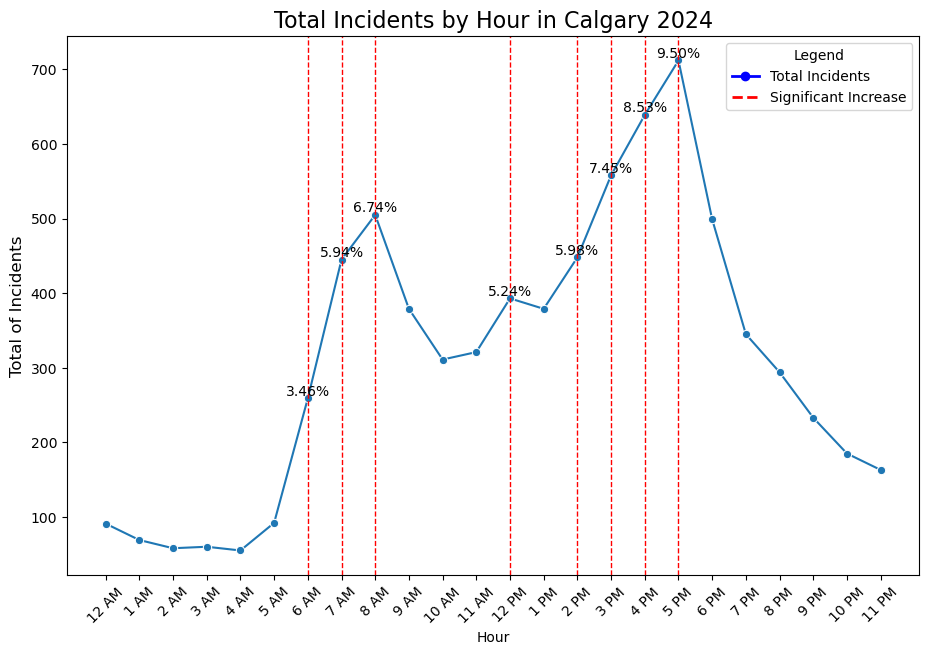

In [25]:
# 3.1.1 Visualize accidents by hour with peaks highlighted.
df_hour = df.groupby('Hour').agg(
    Total = ('Count', 'sum')
).reset_index()


df_hour['Percentage'] =  (df_hour['Total'] / df_hour['Total'].sum()) * 100

def hour_to_ampm(hour):
    if hour == 0:
        return '12 AM'
    elif 1 <= hour < 12:
        return f'{hour} AM'
    elif hour == 12:
        return '12 PM'
    else:
        return f'{hour - 12} PM'

df_hour['Hour'] = df_hour['Hour'].apply(hour_to_ampm)
df_hour.sort_values('Hour').reset_index(drop=True)

# ----------------------

df_hour['Difference'] = df_hour['Total'].diff()

threshold = df_hour['Total'].max() * 0.08
df_hour['Significant Increase'] = df_hour['Difference'] > threshold

# Crear el gráfico
plt.figure(figsize=(11, 7))
sns.lineplot(
    data=df_hour,
    x='Hour',
    y='Total',
    marker='o',
    label='Total Incidents',
)


for i in range(1, len(df_hour)):  
    if df_hour['Significant Increase'].iloc[i]:  
        plt.axvline(x=i, color='red', linestyle='--', linewidth=1)  
        plt.text(
            x=i,
            y=df_hour['Total'].iloc[i],
            s=f'{df_hour['Percentage'].iloc[i]:.2f}%',  
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )


plt.title('Total Incidents by Hour in Calgary 2024', fontsize=16)
plt.ylabel('Total of Incidents', fontsize=12)
plt.xticks(rotation=45)

# Añadir leyenda manualmente para las líneas rojas
red_line = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Significant Increase')
blue_line = plt.Line2D([0], [0], color='blue', linewidth=2, marker='o', label='Total Incidents')

plt.legend(handles=[blue_line, red_line], title="Legend", loc='upper right')


plt.show()

According to the **https://www.calgary.com/blog/driving-calgary-ab/** traffic congestion peaks between 7:00–9:00 a.m. and 4:00–6:00 p.m.

            Hour  Total
0  Not rush hour   4314
1      Rush Hour   3179


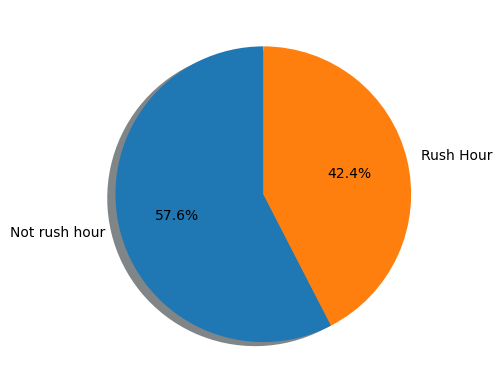

In [27]:
# 3.1.2 Visualize accidents During Rush Hour vs. Non-Rush Hour
def rush_hour(hour):
    return "Rush Hour" if hour in [7, 8, 9, 16, 17, 18] else "Not rush hour"

df_rush_hour = df.groupby(df['Hour'].apply(rush_hour)).agg(
    Total=('Count', 'sum')
).reset_index()

print(df_rush_hour)

labels = df_rush_hour['Hour']
sizes = df_rush_hour['Total']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

This means **42%** of the accidents during the day, occure in the **6h rush hours**

## 3.2 Time-Based Visualizations (Day)
__3.2.1__ Visualize accidents by day 

__3.2.2__ Calculate and visualize the percentage of weekday vs. weekend accidents.

         Day  Daily_counts
0     Monday          1050
1    Tuesday          1187
2  Wednesday          1238
3   Thursday          1211
4     Friday          1214
5   Saturday           898
6     Sunday           695


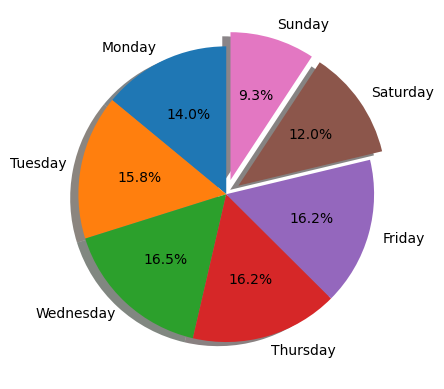

In [30]:
# 3.2.1 Visualize accidents by day
daily_accidents = df.groupby(['Day']).agg(
    Daily_counts = ('Count','sum')
).reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_accidents['Day'] = pd.Categorical(daily_accidents['Day'], categories=day_order, ordered=True)
daily_accidents = daily_accidents.sort_values('Day').reset_index(drop=True)
print(daily_accidents)

# Let's plot
explode = (0, 0, 0, 0, 0 ,0.1 ,0.1)
fig, ax = plt.subplots()
ax.pie(daily_accidents['Daily_counts'], explode=explode, labels=daily_accidents['Day'], autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

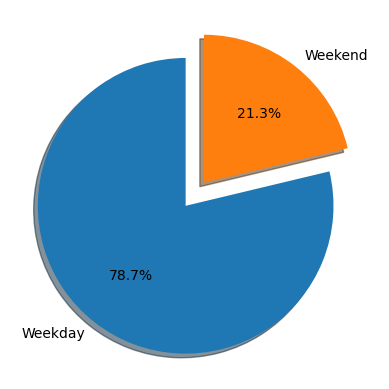

In [31]:
# 3.2.2 Calculate and visualize the percentage of weekday vs. weekend accidents.
Weekday_accidents = df.groupby(['Day_Category']).agg(
    Total=('Count', 'sum')
).reset_index()

explode = [0] * len(Weekday_accidents)  
explode[-2:] = [0.1, 0.1]  

fig, ax = plt.subplots()
ax.pie(
    Weekday_accidents['Total'],
    explode=explode,
    labels=Weekday_accidents['Day_Category'],
    autopct='%1.1f%%',
    startangle=90,
    shadow=True
)

plt.show()

## 3.3 Time-Based Visualizations (Month)
__3.3.1__ Visualize accidents by month  

__3.3.2__ Visualize accidents by season

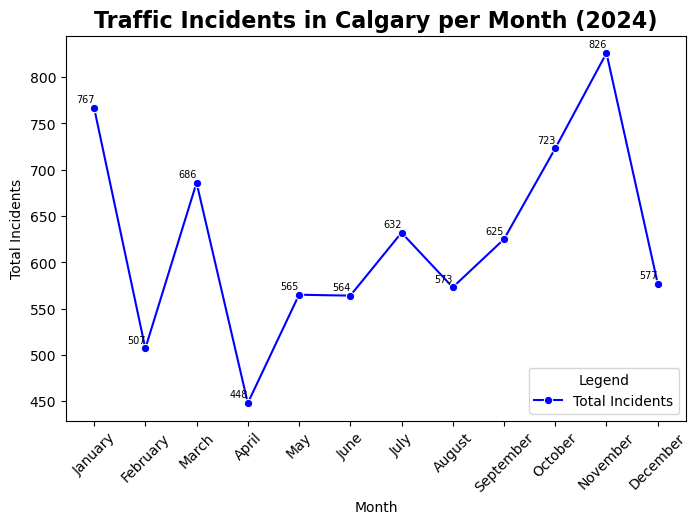

In [33]:
# 3.3.1 Visualize accidents by month

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
df_month = df.groupby('Month', observed=False).agg(
    Total=('Count', 'sum')
).reset_index()


plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=df_month, 
    x='Month', 
    y='Total', 
    marker='o', 
    linestyle='-', 
    color='b', 
    label="Total Incidents"
)

for i, row in df_month.iterrows():
    plt.text(
        x=row['Month'], 
        y=row['Total'] + (max(df_month['Total']) * 0.007),  
        s=f"{row['Total']:,}",  
        ha='right', 
        fontsize=7, 
        color='black'
    )

plt.title("Traffic Incidents in Calgary per Month (2024)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=10)  # Cambié "Day of the Week" a "Month"
plt.ylabel("Total Incidents", fontsize=10)
plt.xticks(rotation=45)
plt.legend(title="Legend", loc='lower right')
plt.show()


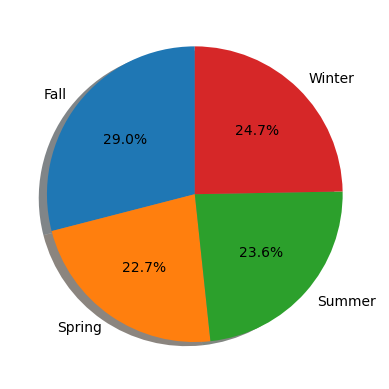

In [34]:
# 3.3.2 Visualize accidents by season
seasonal_accidents = df.groupby(['Season']).agg(
    season_acc = ('Count','sum')
).reset_index()

seasonal_accidents

labels = seasonal_accidents['Season']
sizes = seasonal_accidents['season_acc']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

## 3.3 Time-Based Visualizations (Others)
__3.3.1__ Visualization of Accidents by Quadrant

  QUADRANT  Total_count
0       NE         2229
1       NW         1600
2       SE         2294
3       SW         1370


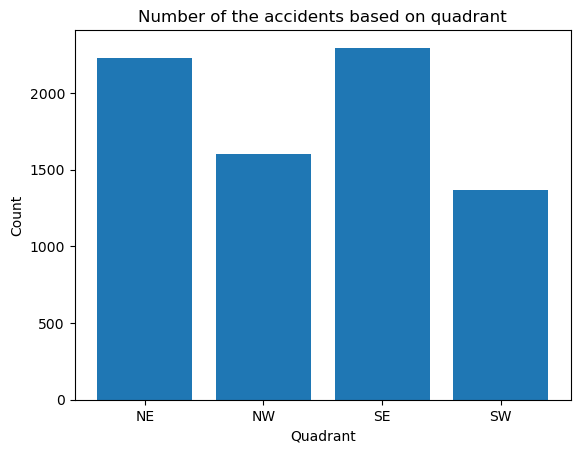

In [36]:
quadrant = df.groupby(['QUADRANT']).agg(
    Total_count = ('Count','sum')
).reset_index()
print(quadrant)
plt.bar( x = quadrant['QUADRANT'], height=quadrant['Total_count'])
plt.xlabel('Quadrant')
plt.ylabel('Count')
plt.title('Number of the accidents based on quadrant')
plt.show()

# Part 4: Merging Additional Datasets
## 4.1 Preparing the weather dataset to merge with the incident dataset 

__1.4.1__ Load the dataset and display its shape, column names, and data types.

__1.4.2__ Identify and list the percentage of missing values in each column.

__1.4.3__ Drop columns with excessive missing values (>40% missing) 

__1.4.5__ For numerical columns, fill missing values using the KNNImputer based on their nearest neighbors.

__1.4.6__ Prepare the weather dataset for an optimal merge with the incident dataset by ensuring consistency in formats, column names, and data alignment.

In [38]:
# 1.4.1 Load the dataset and display its shape, column names, and data types.
df1 = pd.read_csv('en_climate_daily_AB_3031092_2024_P1D.csv')
df1.shape             #shape
df1.columns           #Columns names
df1.info              # data types 

# 1.4.2 Identify and list the percentage of missing values in each column.
percent_missing = df1.isnull().mean() * 100 

# 1.4.3 Drop columns with more than 40% missing values.
percent_missing = df1.isnull().mean() * 100                          #Missing data for each column
drop_columns = df1.columns[(percent_missing/100) > 0.4].tolist()     #Identify columns or rows with more than 40% missing values
df2 = df1.drop(drop_columns, axis=1)                                 #Drop columns in a new DF called df2 



########################## Code to display the output in a well-organized format #####################################
# 1.4.1 Load the dataset and display its shape, column names, and data types.
print('\n')
print((' '*10),'1.4.1 LOAD THE DATASET AND DISPLAY ITS SHAPE, COLUMNS, AND DATA TYPES.', '\n')
print(('_'*40), 'SHAPE OF THE df',('_'*40 ))
print('\n','The shape of the df is',df2.shape[0],'rows and',df2.shape[1],'columns','\n')
print(('_'*38), 'NAME OF EACH COLUMN',('_'*38 ), '\n')
print(df2.columns)
print(('_'*36), 'DATA TYPE IN EACH COLUMN',('_'*36 ))
print(df2.info(), '\n')

# 1.4.2. Identify and list the number of missing values in each column.
print((' '*13),'1.4.2 IDENTIFY AND LIST THE PERCENTAGE OF MISSING VALUES IN EACH COLUMN')
print('_'*97)
print(percent_missing)

# 1.4.3 Drop columns with more than 40% missing values.
print(('_'*25), '1.4.3 COLUMNS DROPED WITH MORE THAN 40% MISSING VALUES',('_'*25))
print(drop_columns)
print('_'*100, '\n')



           1.4.1 LOAD THE DATASET AND DISPLAY ITS SHAPE, COLUMNS, AND DATA TYPES. 

________________________________________ SHAPE OF THE df ________________________________________

 The shape of the df is 366 rows and 18 columns 

______________________________________ NAME OF EACH COLUMN ______________________________________ 

Index(['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time', 'Year', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)',
       'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)'],
      dtype='object')
____________________________________ DATA TYPE IN EACH COLUMN ____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     -----

In [39]:
# 1.4.5 For numerical columns, fill missing values using the KNNImputer based on their nearest neighbors.
num_cols = df2.select_dtypes(include=['float64', 'int64']).columns  
knn = KNNImputer(n_neighbors=4)  
df2[num_cols] = knn.fit_transform(df2[num_cols]) 

percent_missing = df2.isnull().mean() * 100  
percent_missing

Longitude (x)                0.0
Latitude (y)                 0.0
Station Name                 0.0
Climate ID                   0.0
Date/Time                    0.0
Year                         0.0
Month                        0.0
Day                          0.0
Max Temp (°C)                0.0
Min Temp (°C)                0.0
Mean Temp (°C)               0.0
Heat Deg Days (°C)           0.0
Cool Deg Days (°C)           0.0
Total Rain (mm)              0.0
Total Snow (cm)              0.0
Total Precip (mm)            0.0
Dir of Max Gust (10s deg)    0.0
Spd of Max Gust (km/h)       0.0
dtype: float64

In [40]:
# 1.4.6 Prepare the weather dataset for an optimal merge with the incident dataset by ensuring consistency in formats, column names, and data alignment
df2 = df2.drop(columns=['Year', 'Month','Day', 'Longitude (x)', 'Latitude (y)', 'Station Name' ]) # dropping these three columns, since they already exist in the df
df2['Date/Time'] = pd.to_datetime(df2['Date/Time'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Climate ID                 366 non-null    float64       
 1   Date/Time                  366 non-null    datetime64[ns]
 2   Max Temp (°C)              366 non-null    float64       
 3   Min Temp (°C)              366 non-null    float64       
 4   Mean Temp (°C)             366 non-null    float64       
 5   Heat Deg Days (°C)         366 non-null    float64       
 6   Cool Deg Days (°C)         366 non-null    float64       
 7   Total Rain (mm)            366 non-null    float64       
 8   Total Snow (cm)            366 non-null    float64       
 9   Total Precip (mm)          366 non-null    float64       
 10  Dir of Max Gust (10s deg)  366 non-null    float64       
 11  Spd of Max Gust (km/h)     366 non-null    float64       
dtypes: datet

In [41]:
# In order to merge df and df2, I will need to create a similar Date/Time column in df
df['Date/Time'] = df['START_DT'].dt.date
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   INCIDENT INFO  7493 non-null   object         
 1   DESCRIPTION    7493 non-null   object         
 2   START_DT       7493 non-null   datetime64[ns] 
 3   MODIFIED_DT    7493 non-null   datetime64[ns] 
 4   QUADRANT       7493 non-null   object         
 5   Longitude      7493 non-null   float64        
 6   Latitude       7493 non-null   float64        
 7   Count          7493 non-null   int64          
 8   id             7493 non-null   object         
 9   Point          7493 non-null   object         
 10  DIFFERENCE     7493 non-null   timedelta64[ns]
 11  Hour           7493 non-null   int32          
 12  Day            7493 non-null   object         
 13  Month          7493 non-null   category       
 14  Year           7493 non-null   int32          
 15  Day_

## 4.2  Merge with Weather Data

In [43]:
df = df.merge(df2,how = 'left', on = 'Date/Time')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   INCIDENT INFO              7493 non-null   object         
 1   DESCRIPTION                7493 non-null   object         
 2   START_DT                   7493 non-null   datetime64[ns] 
 3   MODIFIED_DT                7493 non-null   datetime64[ns] 
 4   QUADRANT                   7493 non-null   object         
 5   Longitude                  7493 non-null   float64        
 6   Latitude                   7493 non-null   float64        
 7   Count                      7493 non-null   int64          
 8   id                         7493 non-null   object         
 9   Point                      7493 non-null   object         
 10  DIFFERENCE                 7493 non-null   timedelta64[ns]
 11  Hour                       7493 non-null   int32        

## 4.3 Feature Engineering with Weather Data

Create new features based on weather conditions.

__4.3.1__ Binary flags for above/below 0°C.

__4.3.2__ Categories for rainfall intensity (e.g., light, Moderate, Heavy).

__4.3.3__ Categories for snowfall intensity (e.g., light, Moderate, Heavy).

In [45]:
# 4.3.1 Binary flags for above/below 0°C
def below_zero(temp):
    if temp <= 0:
        return 'Below zero'
    else:
        return 'Above Zero'

df['Below or Above Zero'] = df['Mean Temp (°C)'].apply(below_zero)

[Rain Precipitation Definition](https://climate.weather.gc.ca/glossary_e.html)

Rain intensity is classified as "Light" for rates up to 2.5 mm per hour, "Moderate" for rates between 2.6 mm and 7.5 mm per hour, and "Heavy" for rates exceeding 7 mm per hour.

In [47]:
# 4.3.2 Categories for rainfall intensity (e.g., light, Moderate, Heavy).
def classify_rainfall(total_rain):
    if total_rain <= 0:  
        return "No Rain"
    
    rainfall_duration = 1.37           #Average Precipitation in Calgary (2024)
    hourly_intensity = total_rain / rainfall_duration  

    if hourly_intensity <= 2.5:
        return "Light"
    elif hourly_intensity <= 7.5:
        return "Moderate"
    else:
        return "Heavy"

df["Rainfall Category"] = df["Total Rain (mm)"].apply(classify_rainfall)


# 4.3.3 Categories for snowfall intensity (e.g., light, Moderate, Heavy).
def classify_snowfall(total_snow):
    if total_snow <= 0:  
        return "No Snow"
    
    snowfall_duration = 1.37  
    hourly_intensity = total_snow / snowfall_duration  

    if hourly_intensity <= 2.5:
        return "Light Snow"
    elif hourly_intensity <= 7.5:
        return "Moderate Snow"
    else:
        return "Heavy Snow"

df["Snowfall Category"] = df["Total Snow (cm)"].apply(classify_snowfall)

df.head(2)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,...,Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),Below or Above Zero,Rainfall Category,Snowfall Category
0,14 Street and 16 Avenue NW,Traffic incident.,2024-11-12 18:14:13,2024-11-12 19:18:05,NW,-114.096037,51.067018,1,2024-11-12T18:14:1351.06701776006629-114.09603...,POINT (-114.09603722789542 51.06701776006629),...,13.5,0.0,0.0,0.0,0.0,25.0,44.0,Above Zero,No Rain,No Snow
1,42 Avenue and 6 Street SE,Traffic incident.,2024-08-10 12:23:33,2024-08-10 12:58:32,SE,-114.049847,51.015928,1,2024-08-10T12:23:3351.01592778071953-114.04984...,POINT (-114.04984663534405 51.01592778071953),...,0.5,0.0,0.0,0.0,0.0,14.0,45.0,Above Zero,No Rain,No Snow


# Part 5: Advanced Analysis with Weather Data
## 5.1 Weather-Based Aggregations
Calculate:

__5.1.1__ Percentage of the year with temperatures above 0°C vs. below 0°C.

__5.1.2__ Number of accidents when the temperature was above 0°C vs. below 0°C.

__5.1.3__ Number of accidents on days with rainfall above a certain threshold.

__5.1.4__ Number of accidents on days with snowfall above a certain threshold

In [49]:
# 5.1.1 Percentage of the year with temperatures above 0°C vs. below 0°C.
df2['Below or Above Zero'] = df['Mean Temp (°C)'].apply(below_zero)
df2['Below or Above Zero'].value_counts()

Below or Above Zero
Above Zero    196
Below zero    170
Name: count, dtype: int64

In [50]:
# Number incidents when below zero vs. above zero
below_or_above_zero = df.groupby('Below or Above Zero').agg(
    Incidents = ('Count','sum')
).reset_index()
below_or_above_zero

,Below or Above Zero,Incidents
0,Above Zero,4925
1,Below zero,2568


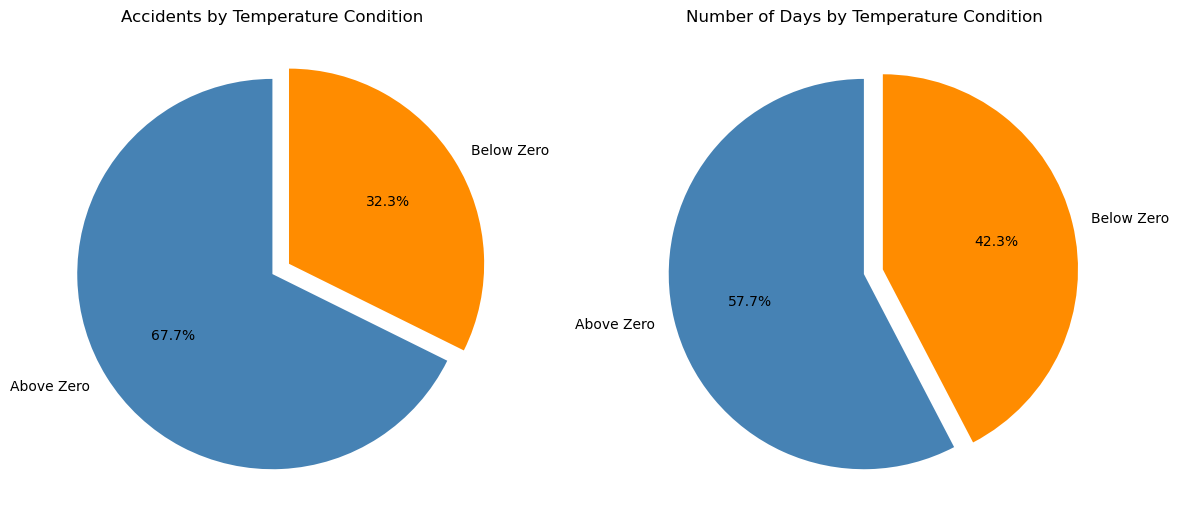

In [51]:
# Let's try to plot these two together. Shall we???

labels = ["Above Zero", "Below Zero"]
explode = (0, 0.1)
# Accident Counts
accident_counts = [5071, 2422]

# Number of Days
number_of_days = [211, 155]

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].pie(accident_counts, labels=labels, autopct='%1.1f%%', colors=["steelblue", "darkorange"], startangle=90, explode = explode)
axes[0].set_title("Accidents by Temperature Condition")

axes[1].pie(number_of_days, labels=labels, autopct='%1.1f%%', colors=["steelblue", "darkorange"], startangle=90, explode = explode)
axes[1].set_title("Number of Days by Temperature Condition")

plt.tight_layout()
plt.show()


According to the pie charts above which compare the number of accidents by temperature condition of above or below zero and the number of days in 2024 when the temperature was above or below zero, even though, the temperature in 42.3% days of the year 2024 was below zero, only 32.3% of the accidents accoured in this temperature condition. This could mean that the drivers are more careful when the weather condition is sub-zero.

In [83]:
#5.1.3 Number of accidents on days with rainfall above a certain threshold.
# Step 1. Use df2 (weather dataset) to count the number of days per year with rainfall and classify the type of rainfall
df2['Rainfall Category'] = df2['Total Rain (mm)'].apply(classify_rainfall)
df2['Count'] = 1

percentage_rain = df2.groupby('Rainfall Category').agg(
    Days=('Count', 'sum')
).reset_index()
percentage_rain['Percentage %'] = (percentage_rain['Days'] / 365).round(2) # Calculate the percentage of days for each rainfall category.



# Step 2. Use df (incident dataset) to count the number of incidents occurring under each rainfall category.  
Rainfall_incidents = df.groupby('Rainfall Category').agg(
    Incidents= ('Count','sum')
).reset_index()



# Step 3. Merge Rainfall_incidents with percentage_rain.  
merged_rainfall = pd.merge(percentage_rain, Rainfall_incidents, on='Rainfall Category', how='inner')
merged_rainfall['Incidents Per Day'] = (merged_rainfall['Incidents']/ merged_rainfall['Days']).round(2)

order = ["Heavy", "Moderate", "Light", "No Rain"]  # Sort the DataFrame based on the defined order
merged_rainfall["Rainfall Category"] = pd.Categorical(merged_rainfall["Rainfall Category"], categories=order, ordered=True)
merged_rainfall = merged_rainfall.sort_values("Rainfall Category").reset_index(drop=True)
merged_rainfall

,Rainfall Category,Days,Percentage %,Incidents,Incidents Per Day
0,Heavy,11,0.03,233,21.18
1,Moderate,11,0.03,156,14.18
2,Light,43,0.12,813,18.91
3,No Rain,301,0.82,6291,20.90


In [89]:
# 5.1.4 Number of accidents on days with snowfall above a certain threshold

# Step 1. Use df2 (weather dataset) to count the number of days per year with snowfall and classify the type of snowfall.
df2['Snowfall Category'] = df2['Total Snow (cm)'].apply(classify_snowfall)
df2['Count'] = 1  # Add a column to count each occurrence  
 
percentage_snow = df2.groupby('Snowfall Category').agg(
    Days=('Count', 'sum')
).reset_index()
percentage_snow['Percentage %'] = (percentage_snow['Days'] / 365).round(2)



# Step 2. Use df (incident dataset) to count the number of incidents occurring under each snowfall category.  
Snowfall_incidents = df.groupby('Snowfall Category').agg(
    Incidents=('Count', 'sum')
).reset_index()




# Step 3. Merge Snowfall_incidents with percentage_snow.  
merged_snowfall = pd.merge(percentage_snow, Snowfall_incidents, on='Snowfall Category', how='inner')
merged_snowfall['Incidents Per Day'] = (merged_snowfall['Incidents'] / merged_snowfall['Days']).round(2)

  
order = ["Heavy Snow", "Moderate Snow", "Light Snow", "No Snow"] # Define the preferred order for snowfall categories.
merged_snowfall["Snowfall Category"] = pd.Categorical(merged_snowfall["Snowfall Category"], categories=order, ordered=True)
merged_snowfall = merged_snowfall.sort_values("Snowfall Category").reset_index(drop=True)
merged_snowfall


,Snowfall Category,Days,Percentage %,Incidents,Incidents Per Day
0,Heavy Snow,4,0.01,142,35.50
1,Moderate Snow,15,0.04,443,29.53
2,Light Snow,30,0.08,744,24.80
3,No Snow,317,0.87,6164,19.44


## 5.2 Correlation Analysis
Analyze correlations between:
- Temperature and accidents.
- Rainfall and accidents.
- Snowfall and accidents.

Visualize correlations using heatmaps or scatter plots.

In [361]:
df['Total Rain (cm)'] = df['Total Rain (mm)'] / 10   # rain (mm) --> rain (cm)

df_correlation = df.groupby('Month').agg(
    sum_counts = ('Count','sum'),
    monthly_snow = ('Total Snow (cm)','sum'),
    monthly_rain = ('Total Rain (cm)','sum')
).reset_index()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December']
df_correlation['Month'] = pd.Categorical(df_correlation['Month'], categories=month_order, ordered=True)
df_correlation = df_correlation.sort_values('Month').reset_index(drop=True)

df_correlation

C:\Users\alain\AppData\Local\Temp\ipykernel_12436\3589781326.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_correlation = df.groupby('Month').agg(


,Month,sum_counts,monthly_snow,monthly_rain
0,January,767,1072.2,3.00
1,February,507,569.3,0.72
2,March,686,2401.9,0.00
3,April,448,573.1,12.70
4,May,565,162.8,96.66
5,June,564,0.0,161.46
6,July,632,0.0,94.82
7,August,573,0.0,157.55
8,September,625,0.0,192.99
9,October,723,21.6,1.08


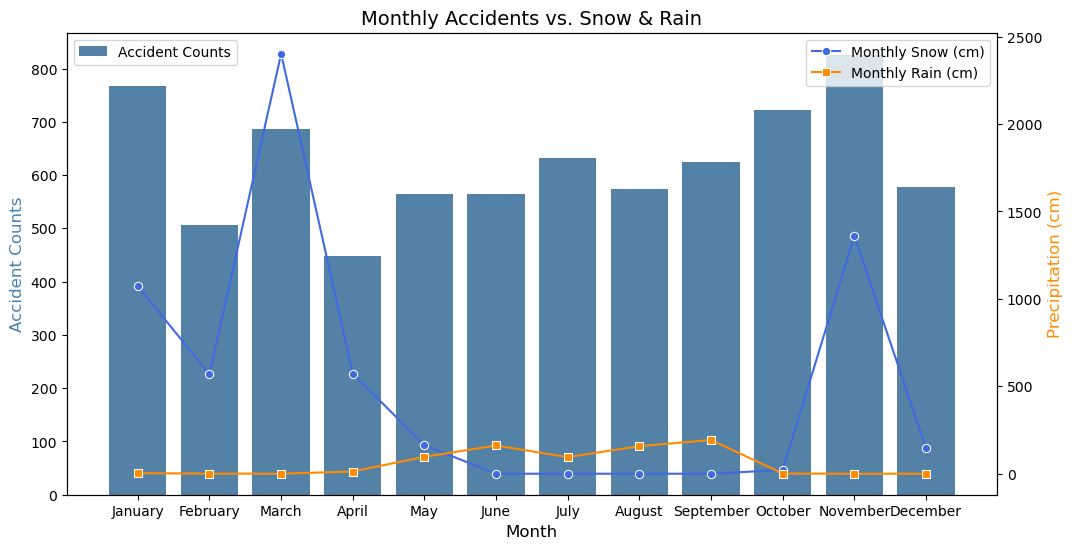

In [363]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for accident counts
sns.barplot(x="Month", y="sum_counts", data=df_correlation, ax=ax1, color="steelblue", label="Accident Counts")

# Create a second y-axis
ax2 = ax1.twinx()

# Line plot for snow and rain
sns.lineplot(x="Month", y="monthly_snow", data=df_correlation, ax=ax2, marker="o", color="royalblue", label="Monthly Snow (cm)")
sns.lineplot(x="Month", y="monthly_rain", data=df_correlation, ax=ax2, marker="s", color="darkorange", label="Monthly Rain (cm)")

# Labels and titles
ax1.set_ylabel("Accident Counts", color="steelblue", fontsize=12)
ax2.set_ylabel("Precipitation (cm)", color="darkorange", fontsize=12)
ax1.set_xlabel("Month", fontsize=12)
ax1.set_title("Monthly Accidents vs. Snow & Rain", fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()

In [60]:
columns_of_interest = ['sum_counts', 'monthly_snow', 'monthly_rain']
df_corr = df_correlation[columns_of_interest].corr()

display(df_corr)

,sum_counts,monthly_snow,monthly_rain
sum_counts,1.000000,0.435429,-0.269343
monthly_snow,0.435429,1.000000,-0.561272
monthly_rain,-0.269343,-0.561272,1.000000


## 5.3 Scatterplot and Heatmap of Traffic Incident Hotspots

C:\Users\alain\AppData\Local\Temp\ipykernel_12436\1179081954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lonlat['Lon100'] = lonlat['Longitude'].apply(lambda x: round(x * 100))
C:\Users\alain\AppData\Local\Temp\ipykernel_12436\1179081954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lonlat['Lat100'] = lonlat['Latitude'].apply(lambda x: round(x * 100))
C:\Users\alain\AppData\Local\Temp\ipykernel_12436\1179081954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

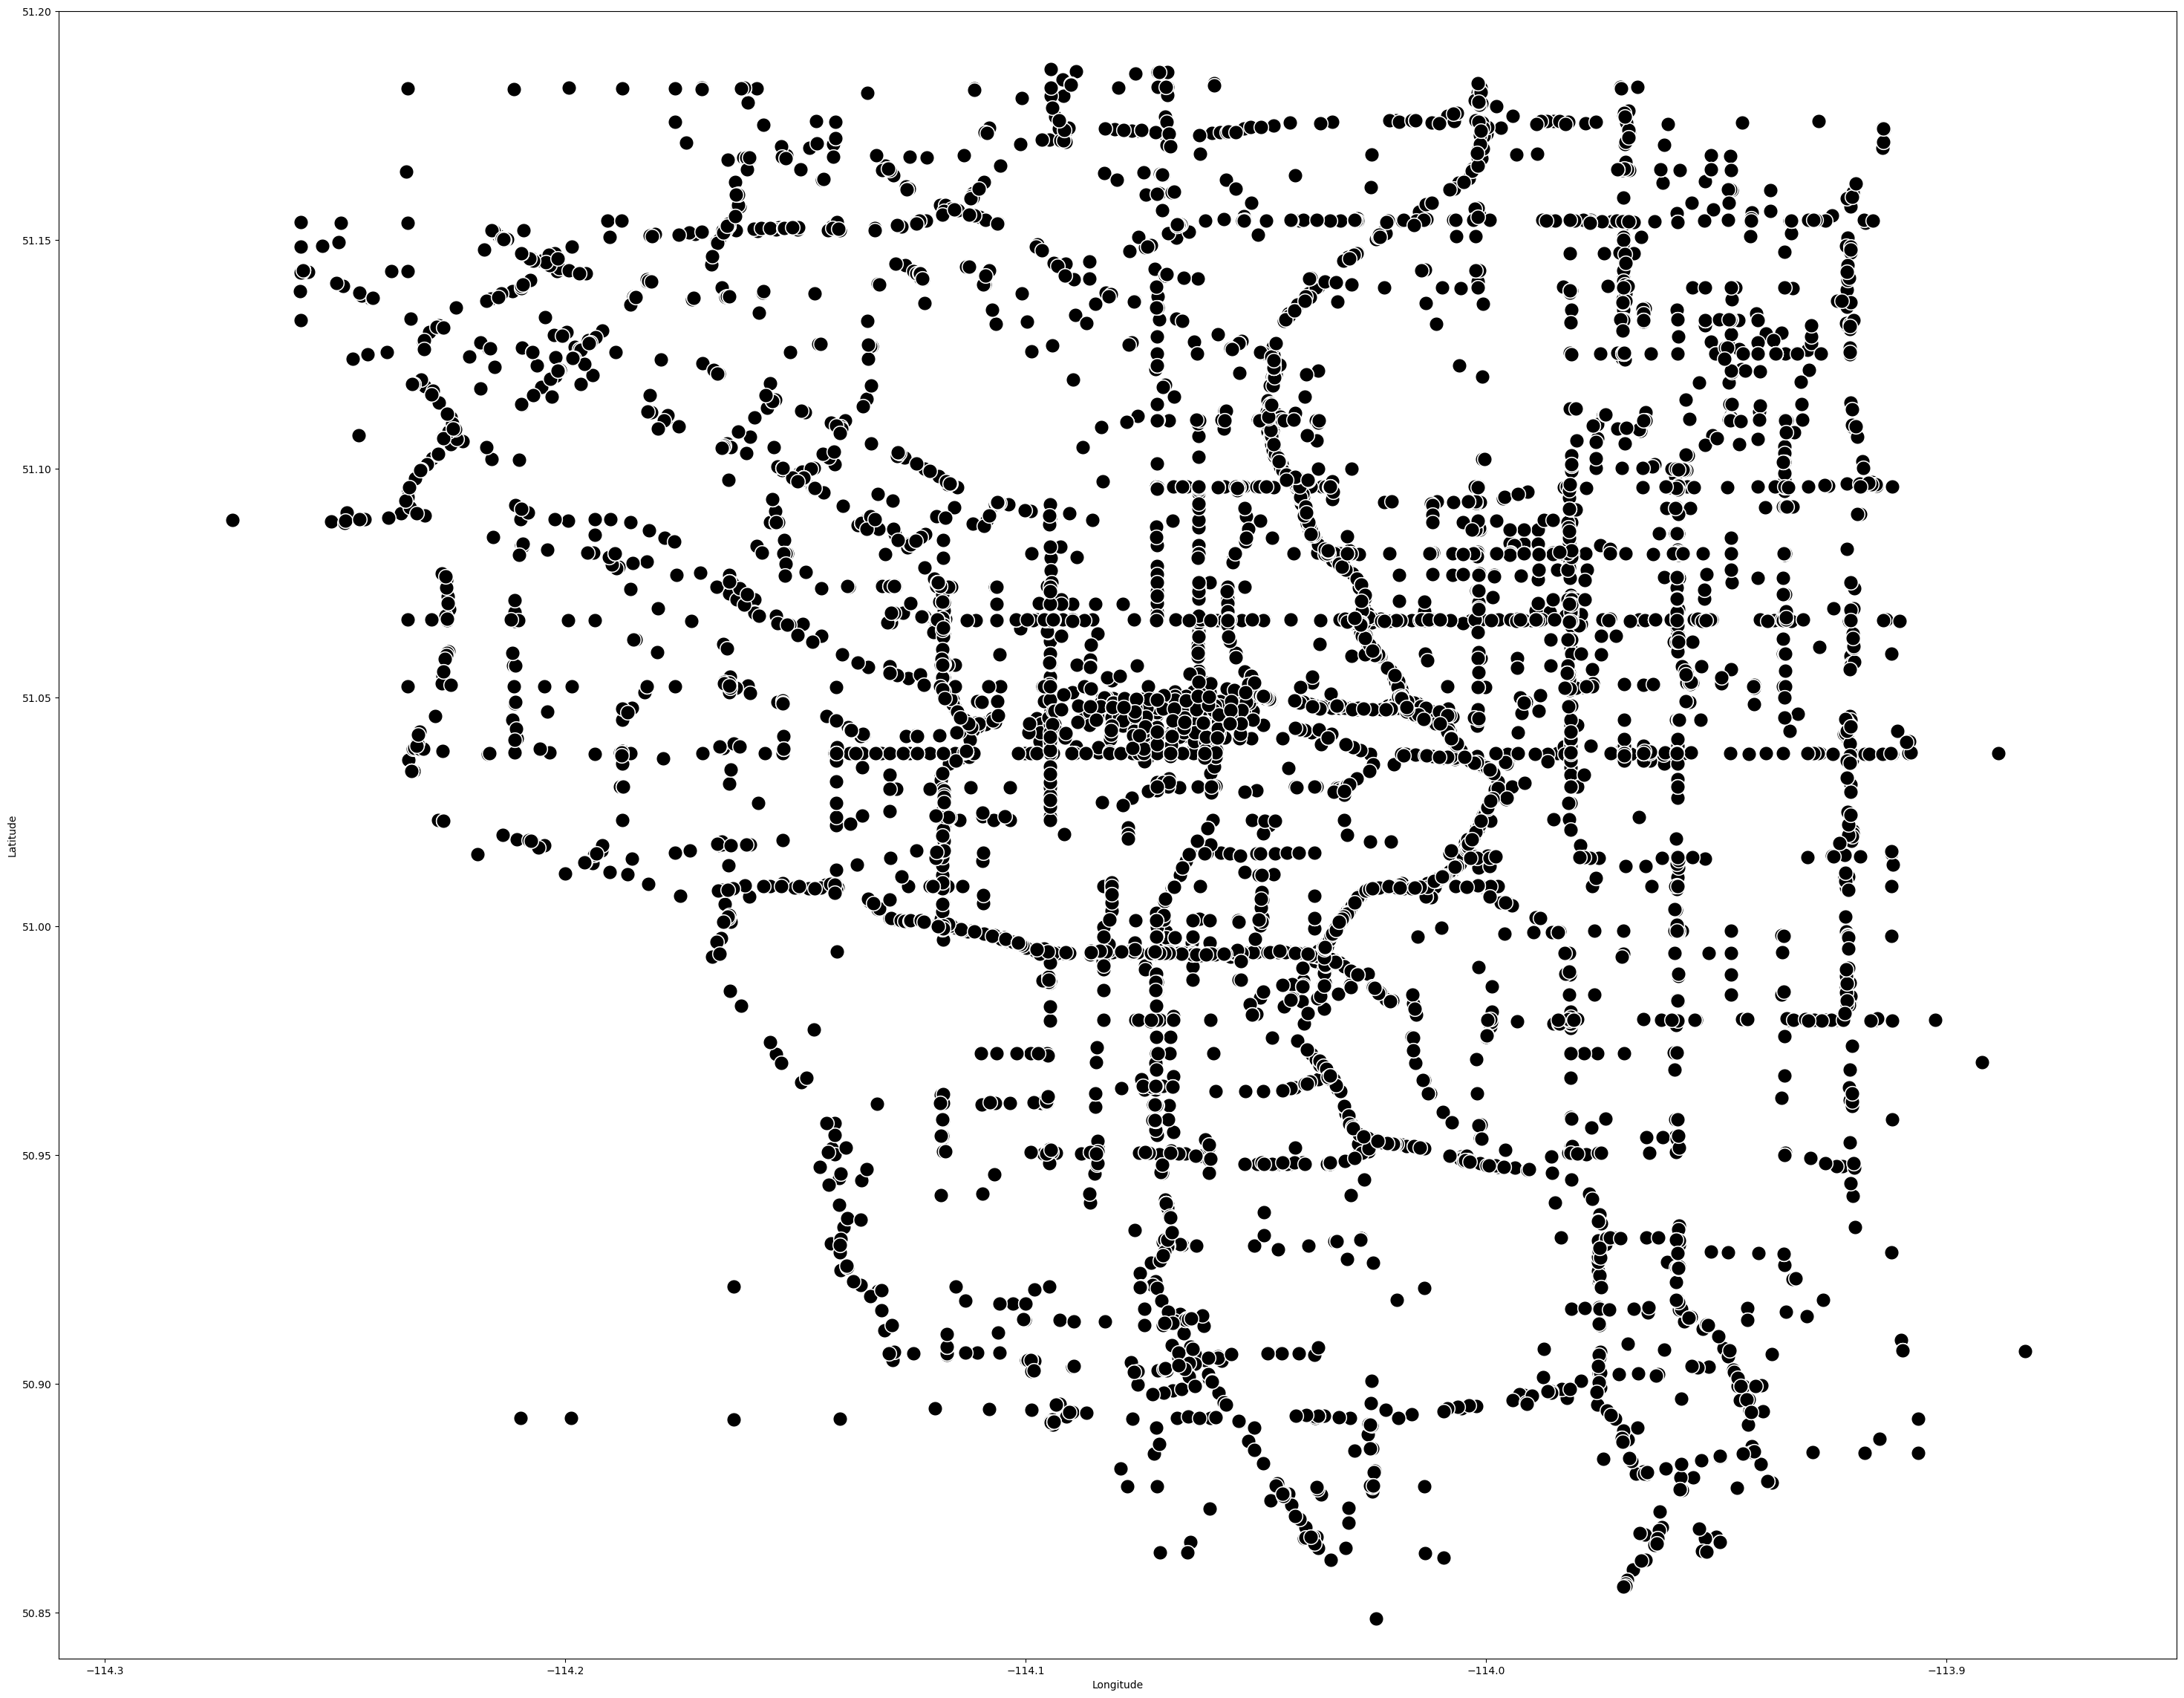

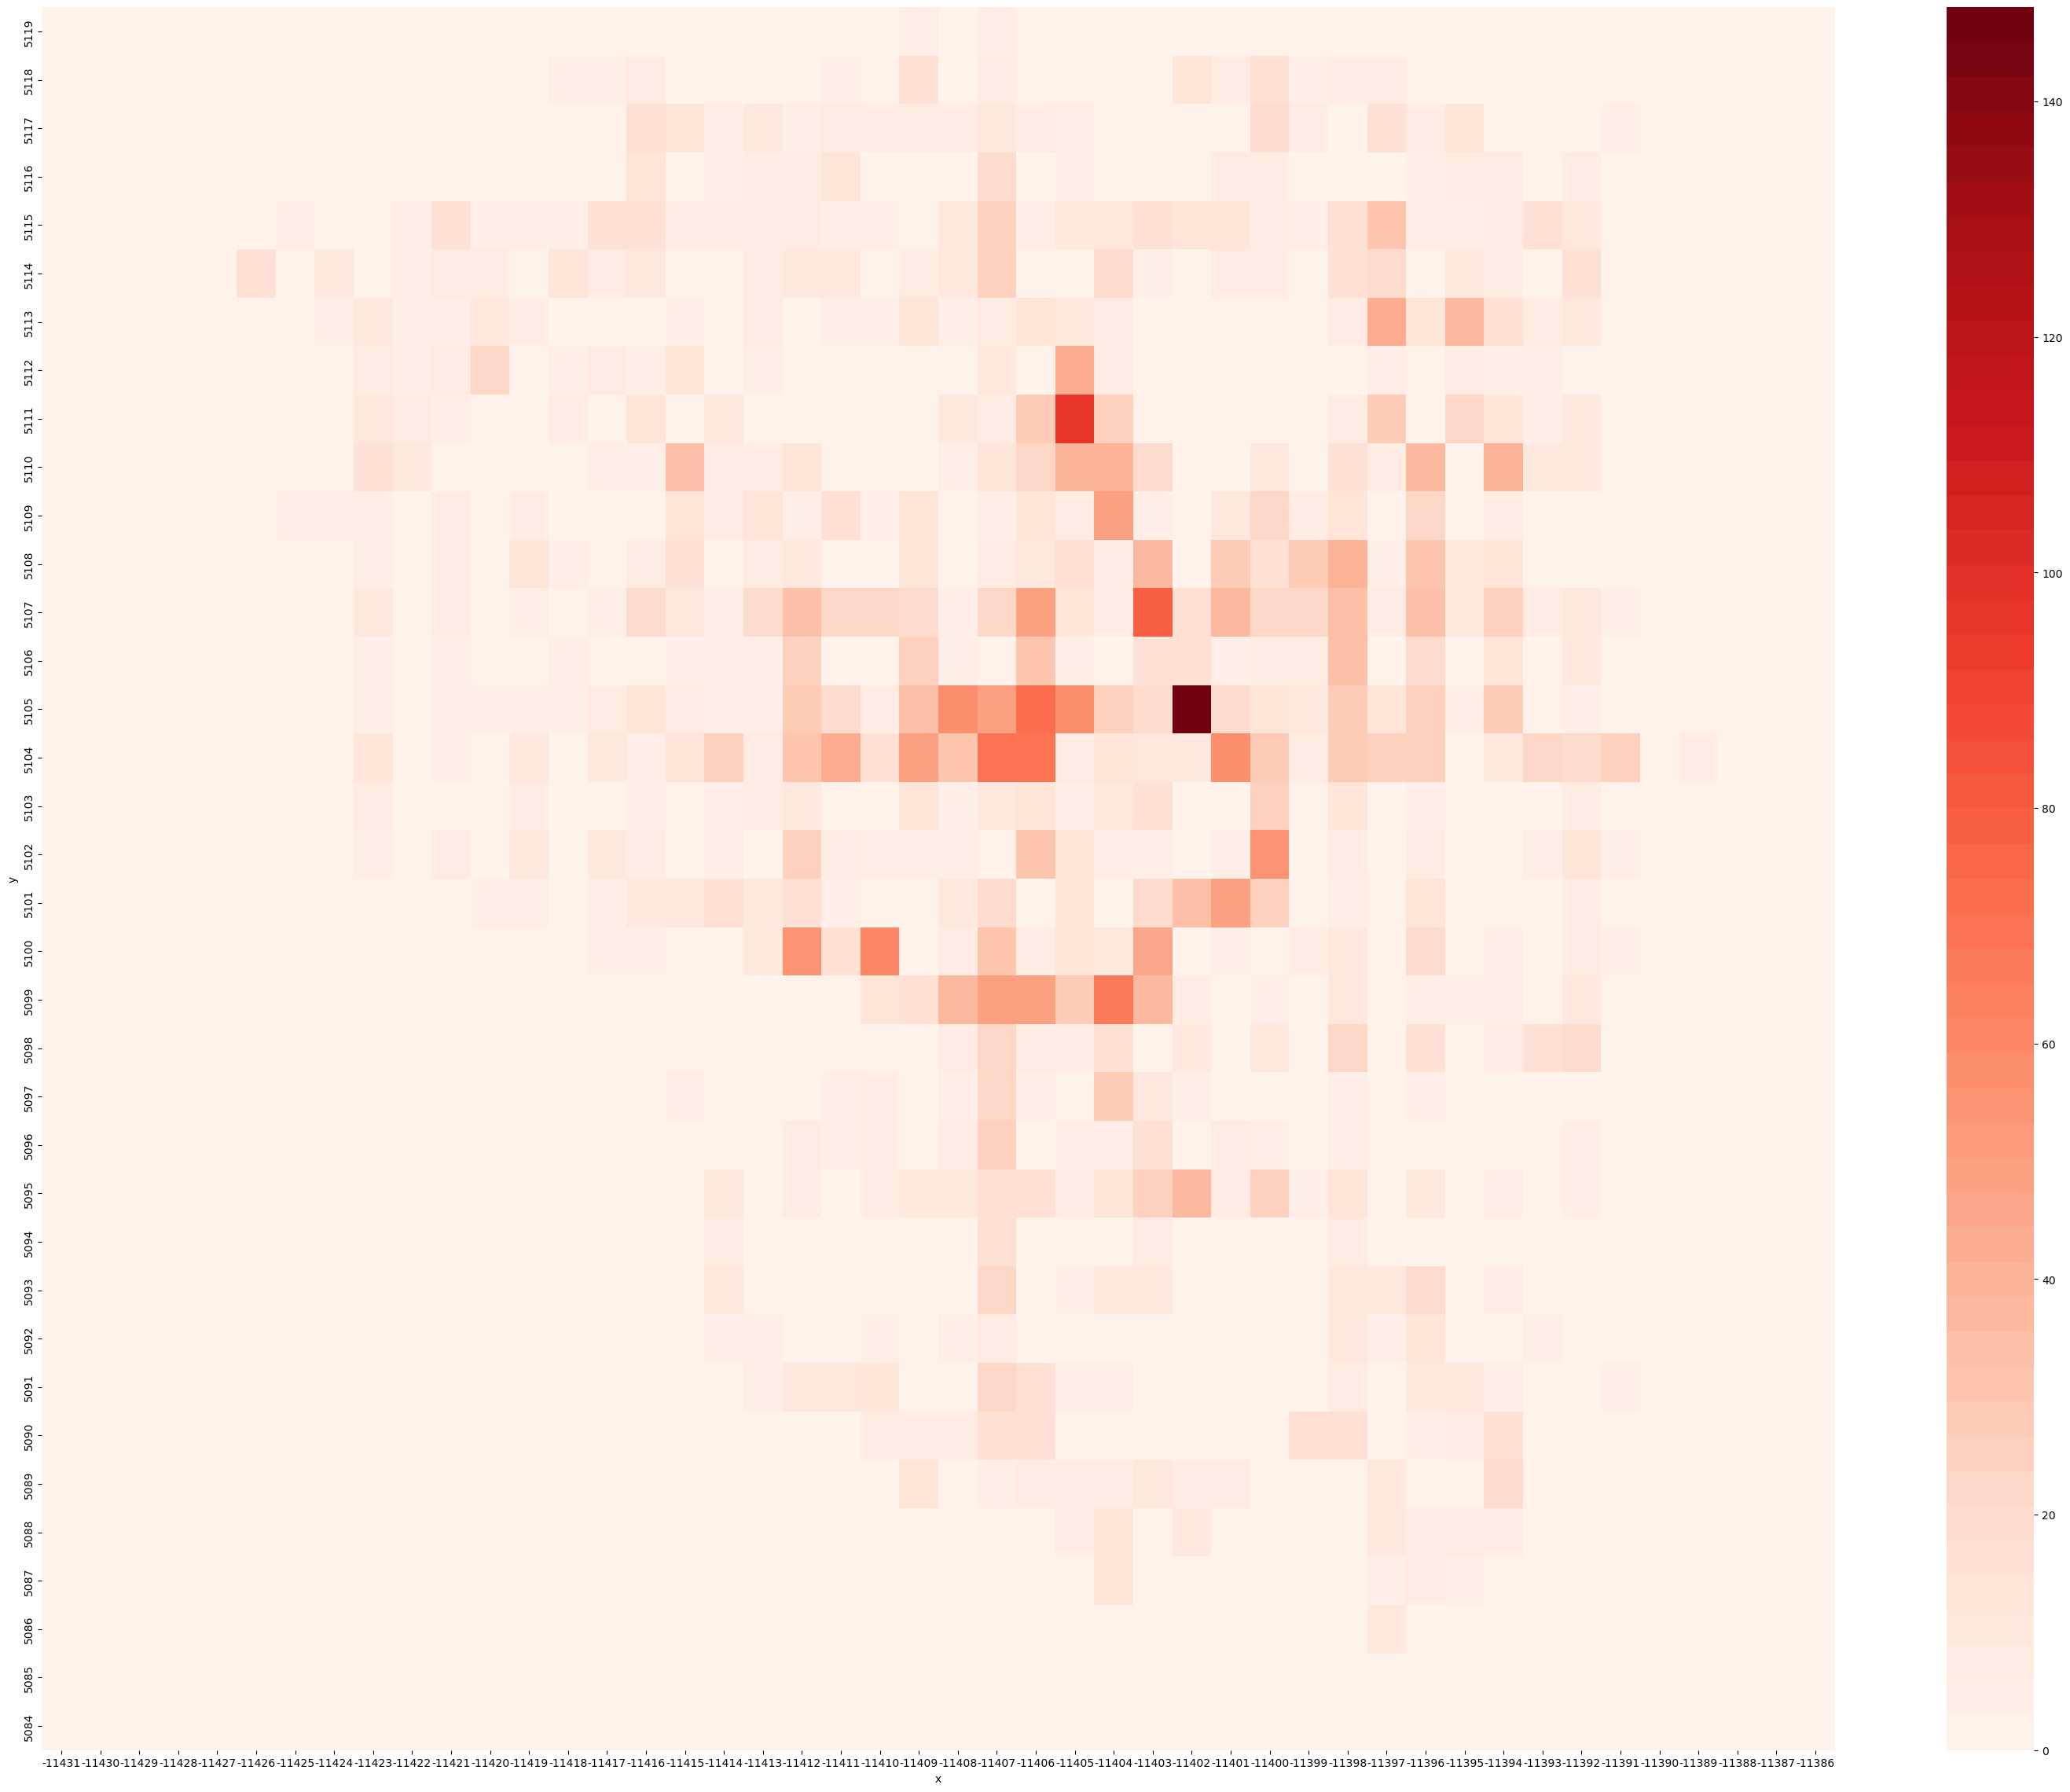

In [370]:
lonlat = df[['Longitude', 'Latitude']]
lonlat['Lon100'] = lonlat['Longitude'].apply(lambda x: round(x * 100))
lonlat['Lat100'] = lonlat['Latitude'].apply(lambda x: round(x * 100))
lonlat['ID'] = lonlat['Lon100'].astype(str) + lonlat['Lat100'].astype(str)

mult = 100
mapxmin = -114.31
mapxmax = -113.85
mapymin = 50.84
mapymax = 51.20
xrange = pd.DataFrame(range(int(mapxmin*mult), int(mapxmax*mult)))
yrange = pd.DataFrame(range(int(mapymin*mult), int(mapymax*mult)))

xy = pd.merge(xrange, yrange, how='cross')
xy.columns = ['x', 'y']
xy['ID'] = xy['x'].astype(str) + xy['y'].astype(str)
counts = lonlat.groupby('ID').agg(Count=('Longitude', 'count'))

xy = pd.merge(xy, counts, on='ID', how='left')
xy['Count'] = xy['Count'].fillna(0)
xy['Count'] = pd.to_numeric(xy['Count'], downcast='integer')

mapsize = 80
plt.figure(figsize=((mapxmax-mapxmin)*mapsize, (mapymax-mapymin)*mapsize))
sns.scatterplot(lonlat, x=lonlat['Longitude'], y=lonlat['Latitude'], s=200, color='black')
plt.xlim(mapxmin, mapxmax)
plt.ylim(mapymin, mapymax)
plt.show()

plt.figure(figsize=((mapxmax-mapxmin)*mapsize, (mapymax-mapymin)*mapsize))
ax = sns.heatmap(xy.pivot(index='y', columns='x', values='Count'), cmap=sns.color_palette('Reds', 50) )
ax.invert_yaxis()
plt.show()

### Rain and snow fall based on the month

#### 1. Rain

In [50]:
rain_month = df.groupby(['Month']).agg(
    monthly_rain = ('Total Rain (mm)','sum')
).reset_index()
rain_month

C:\Users\alain\AppData\Local\Temp\ipykernel_8412\2916549017.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rain_month = df.groupby(['Month_x']).agg(


,Month_x,monthly_rain
0,January,30.000000
1,February,7.200000
2,March,0.000000
3,April,127.000000
4,May,966.600000
5,June,1614.600000
6,July,948.200000
7,August,1582.444756
8,September,1929.900000
9,October,10.800000


      Month_x  monthly_rain
0     January     30.000000
1    February      7.200000
2       March      0.000000
3       April    127.000000
4         May    966.600000
5        June   1614.600000
6        July    948.200000
7      August   1582.444756
8   September   1929.900000
9     October     10.800000
10   November      0.000000
11   December      1.800000


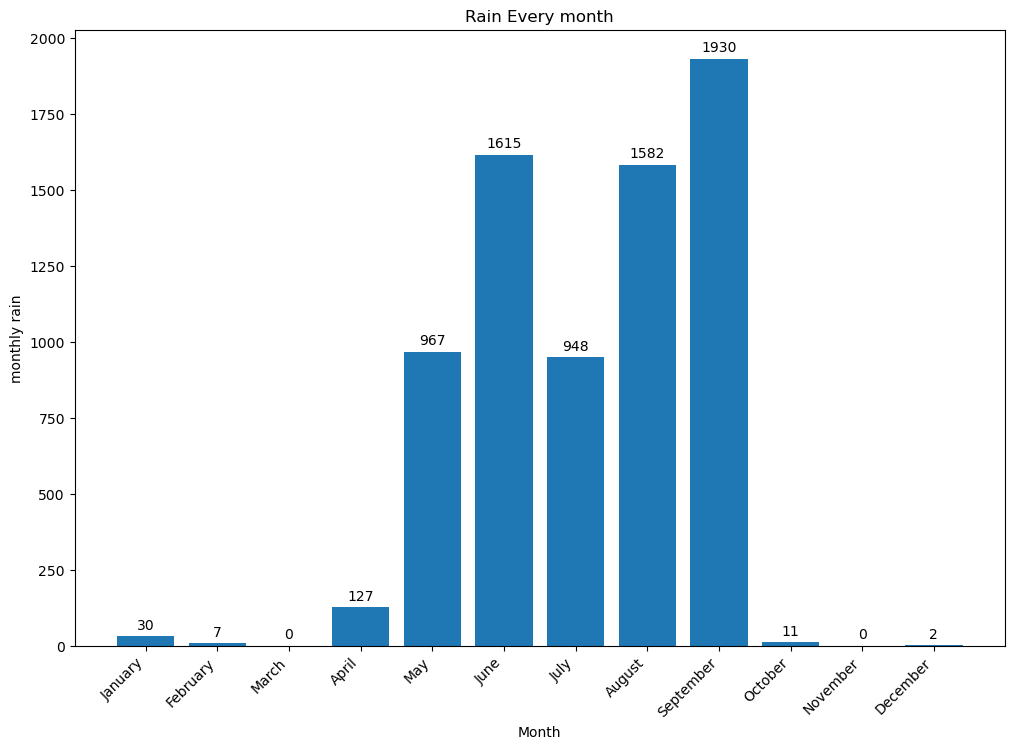

In [51]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December']
rain_month['Month'] = pd.Categorical(rain_month['Month'], categories=month_order, ordered=True)
rain_month = rain_month.sort_values('Month').reset_index(drop=True)
print(rain_month)

plt.figure(figsize=(12,8))
bars = plt.bar(data = rain_month,x= rain_month['Month'], height=rain_month['monthly_rain'])
plt.bar_label(bars, fmt='%.0f', padding=3, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('monthly rain')
plt.title('Rain Every month')

plt.show()

**Snow**

In [1]:
snow_month = df.groupby(['Month']).agg(
    monthly_snow = ('Total Snow (cm)','sum')
).reset_index()
snow_month

NameError: name 'df' is not defined

,Month_x,monthly_snow
0,January,1072.200000
1,February,569.300000
2,March,2401.900000
3,April,573.100000
4,May,162.800000
5,June,0.000000
6,July,0.000000
7,August,31.303608
8,September,0.000000
9,October,21.600000


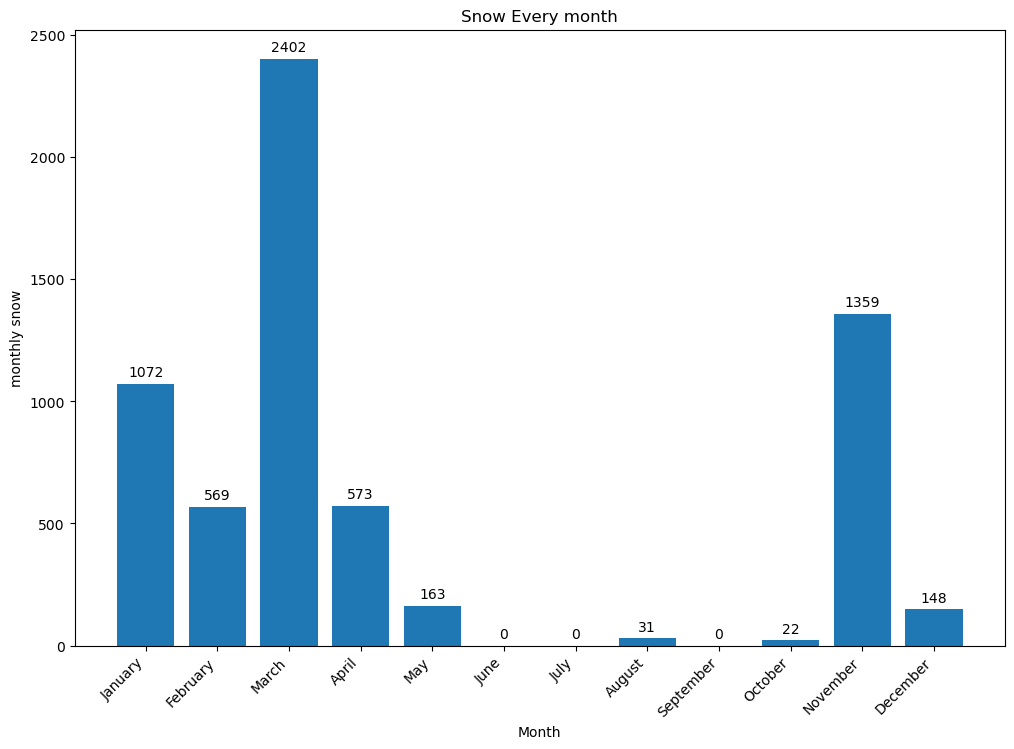

In [54]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December']
snow_month['Month'] = pd.Categorical(snow_month['Month'], categories=month_order, ordered=True)
snow_month = snow_month.sort_values('Month').reset_index(drop=True)
display(snow_month)

plt.figure(figsize=(12,8))
bars = plt.bar(data = snow_month,x= snow_month['Month'], height=snow_month['monthly_snow'])
plt.bar_label(bars, fmt='%.0f', padding=3, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('monthly snow')
plt.title('Snow Every month')

plt.show()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7493 entries, 0 to 7492
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   INCIDENT INFO              7493 non-null   object         
 1   DESCRIPTION                7493 non-null   object         
 2   START_DT                   7493 non-null   datetime64[ns] 
 3   MODIFIED_DT                7493 non-null   datetime64[ns] 
 4   QUADRANT                   7493 non-null   object         
 5   Longitude                  7493 non-null   float64        
 6   Latitude                   7493 non-null   float64        
 7   Count                      7493 non-null   int64          
 8   id                         7493 non-null   object         
 9   Point                      7493 non-null   object         
 10  DIFFERENCE                 7493 non-null   timedelta64[ns]
 11  Hour                       7493 non-null   int32        

### Correlation between the temperature and number of accidents

In [365]:
df_correlation2 = df.groupby('Date/Time').agg(
    sum_counts = ('Count','sum'),
    mean_temp = ('Mean Temp (°C)','mean')
).reset_index()
df_correlation2

,Date/Time,sum_counts,mean_temp
0,2024-01-01,15,0.000
1,2024-01-02,20,-2.100
2,2024-01-03,17,-6.200
3,2024-01-04,24,-2.000
4,2024-01-05,23,0.100
...,...,...,...
361,2024-12-27,10,0.400
362,2024-12-28,13,-3.125
363,2024-12-29,10,-5.100
364,2024-12-30,16,-5.000


In [367]:
columns_of_interest2 = ['sum_counts', 'mean_temp']
df_corr2 = df_correlation2[columns_of_interest2].corr()

display(df_corr2)

,sum_counts,mean_temp
sum_counts,1.00000,-0.26035
mean_temp,-0.26035,1.00000


**This kinda contracting the pie graphs. WE SHOULD DISCUSS THIS IN THE CLASS TOGETHER and come up with an explaination for what we are seeing**